In [1]:
from __future__ import unicode_literals
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn

In [2]:
pd.set_option("display.max_colwidth", 100)

In [3]:
df = pd.read_csv('aggregation.csv')
df.head()

,text,retweet_count,favorite_count,username,userdesc,verified,followers,created_at,has_urls,has_mentions,high_response
0,They are starting to get more and more desperate...\nThis shows that we’re winning. https://t.co...,24298,168648,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4079169,2020-02-29 15:26:10,True,False,True
1,I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the I...,18592,77895,BernieSanders,U.S. Senator from Vermont and candidate for President of the United States.,True,10951634,2020-03-02 20:30:56,False,False,True
2,Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround https://t.co/1kYNumyoQT,4609,21488,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4086646,2020-02-08 13:36:48,True,False,True
3,"Stop running away from your problem. Run into your problem. It will suck. Really suck. But, wh...",2739,16317,pulte,"The Philanthropist. Inventor of Twitter Philanthropy. Giving Money, Food, and Rent To People In ...",True,2059165,2020-02-29 21:19:22,True,False,True
4,Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStro...,2972,10035,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4091979,2020-02-18 10:13:02,True,False,True


In [4]:
from sklearn.pipeline import Pipeline

# Tutorials:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [5]:
tweet_corpus = list(df['text'])

In [6]:
# Remove URL junk
url_pattern = re.compile("http[^\s]+", re.I)

for i in range(len(tweet_corpus)):
    tweet_corpus[i] = url_pattern.sub('', tweet_corpus[i])

In [7]:
print(tweet_corpus[:5])

['They are starting to get more and more desperate...\nThis shows that we’re winning. ', 'I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the Iraq War. ', 'Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround ', 'Stop running away from your problem. Run into your problem.  It will suck.  Really suck. But, when you pop out the… ', 'Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStrong  ']


In [8]:
hashtag_pattern = re.compile("#[^\s]+", re.I)

for i in range(20):
    matches = hashtag_pattern.findall(tweet_corpus[i])
    if matches:
        print(matches)

['#WetsuwetenStrong', '#KeepItInTheGround']
['#WetsuwenStrong']
['#CoastalGasLink']
['#Greece', '#Athens', '#EU']
['#Wetsuweten']
['#WetsuwetenSolidarity']


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

add_stop_words = ['wetsuweten', 'wet', 'suwet', 'en',
                  'wetsuwetenstrong', 'wetsuwetensolidarity', 'shutdowncanada',
                    'bc', 'british', 'columbia', 'canada', 'indigenous', 'pipeline']

custom_stop_words = set(ENGLISH_STOP_WORDS).union(set(add_stop_words))

In [24]:
# Text frequency*Inverse document frequency matrix
# max_df: ignore terms with frequency higher than
# lowercase = True by default
bigrams = TfidfVectorizer(strip_accents='unicode',
                          analyzer='word',
                          stop_words=custom_stop_words,
#                           max_df=0.5,
                          ngram_range=(2,2))
X = bigrams.fit_transform(tweet_corpus)

In [25]:
terms = bigrams.get_feature_names()
print("n-grams:", len(terms))

2- and 3-grams: 23981


In [26]:
# Dimensionality reduction for latent semantic analysis
svd = TruncatedSVD(n_components=100) # Recommended param for TfIdf matrix
normalizer = Normalizer(copy=False)
lsa = Pipeline([
    ('truncated_SVD', svd), 
    ('normalizer', normalizer)
    ])

In [27]:
bigrams = lsa.fit_transform(X)

In [29]:
for n_clusters in range(2,9):
    km_comp = KMeans(n_clusters=n_clusters, random_state=1)
    km_comp.fit(bigrams)
    print("%d\t Silhouette coefficient: %0.3f" % (n_clusters,
                                              metrics.silhouette_score(bigrams, km_comp.labels_)))

2	 Silhouette coefficient: 0.027
3	 Silhouette coefficient: 0.043
4	 Silhouette coefficient: 0.046
5	 Silhouette coefficient: 0.047
6	 Silhouette coefficient: 0.061
7	 Silhouette coefficient: 0.062
8	 Silhouette coefficient: 0.062


In [30]:
km = KMeans(6) # default: n_clusters=8, max_iter=300, n_init=10

In [31]:
km.fit(bigrams)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [32]:
# with SVD
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
# without SVD
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(km.n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :20]:
            print('   %s' % terms[ind], end='')
        print('\n')

Cluster 0:   oil gas   don want   proudca37627925 carolyn_bennett   crowley_shelley proudca37627925   calling reject   hey exportdevcanada   giving coastalgaslink   34 000   reject giving   justintrudeau 34   000 calling   coastalgaslink millions   exportdevcanada mary_ng   mary_ng justintrudeau   canadian government   youth arrested   bcrcmp coastalgaslink   land claim   coastal gas   red dresses

Cluster 1:   scott fraser   supreme court   blockades talks   proposed deal   hurting ajenglish   talks devastate   devastate economies   know title   title say   say accept   way know   blockades place   deal haste   haste blockades   john ivison   ivison curated   place john   delgamuukw decision   historical context   minister scott

Cluster 2:   youth arrested   peoples unite   don know   trudeau tells   big adjustment   industries trudeau   low carbon   tells mining   economy big   carbon economy   adjustment industries   mining conferen   recent protests   non canadians   jjhorgan just

In [33]:
labels = km.labels_.tolist() # [0,1,2...]

In [34]:
km_df_cols = {'user': df['username'], 'text': df['text'], 
              'label': labels}
km_df = pd.DataFrame(km_df_cols)
km_df[:20]

,user,text,label
0,GretaThunberg,They are starting to get more and more desperate...\nThis shows that we’re winning. https://t.co...,1
1,BernieSanders,I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the I...,2
2,GretaThunberg,Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround https://t.co/1kYNumyoQT,1
3,pulte,"Stop running away from your problem. Run into your problem. It will suck. Really suck. But, wh...",3
4,GretaThunberg,Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStro...,0
5,GretaThunberg,Om Friday we strike in Brussels! \nSee you at Central Station 14:00 along with representatives f...,2
6,CanadaAction,Wet’suwet’en Nation member Shirley Wilson supports #CoastalGasLink \n\n“I don’t agree with the p...,2
7,CanadaAction,"This is powerful. Rita George, Wet'suwet'en Matriarch &amp; Hereditary Subchief.\n\n“What’s happ...",1
8,leahstokes,Fellow faculty: Just wanted to share what I've done to help students out with the coronavirus in...,2
9,prageru,THIS is the result of socialism. https://t.co/O0QMPvLsgh,3


In [35]:
grouped = km_df.groupby(km_df['label'])
grouped.size() # tweets in each group

label
0     631
1     586
2     701
3    1442
4     631
5     228
dtype: int64

In [36]:
non_ascii_pattern = re.compile("[^\u0000-\u2300]")
# ellipsis: "\u2026"; currency symbols later

for i in range(200):
    if non_ascii_pattern.search(tweet_corpus[i]):
        print((non_ascii_pattern.findall(tweet_corpus[i])[0]))

👉
👉
✊
❌
✊
🔥


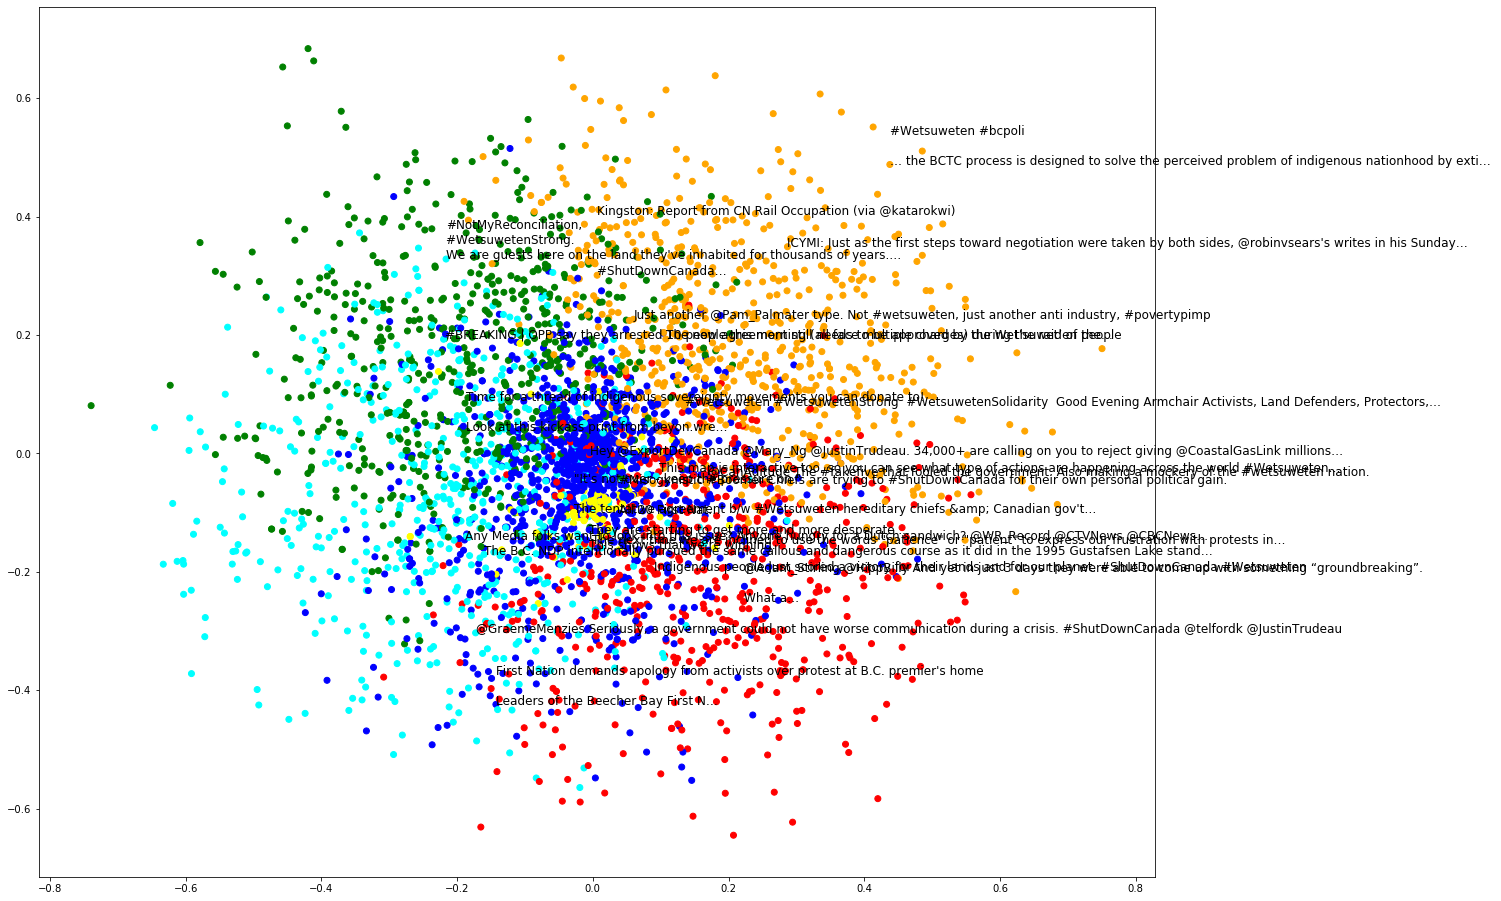

In [38]:
pca = PCA(n_components=2) # Principal Component Analysis: reduce to 2D space
                          # only for sparse input, i.e. SVD
scatter_plot_points = pca.fit_transform(bigrams)

colors = ["red", "cyan", "orange", "blue", "green", "yellow"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,16))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in km.labels_])

for i, txt in enumerate(tweet_corpus):
    if i % 200 != 0:
        continue
    if non_ascii_pattern.search(txt):
        txt = non_ascii_pattern.sub('', txt)
    ax.annotate(txt, xy=(x_axis[i], y_axis[i]), size=12)

In [39]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(bigrams, km.labels_))

Silhouette Coefficient: 0.048
